In [1]:
#!/usr/bin/env python3
import os
import json
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

from src.architecture import FootpathModelArchitecture
from src.miscellaneous import load_random_image, preprocess_image
from src.training_preparation import (create_checkpoint_callback,
                                      create_training_dataset, load_image_test,
                                      load_image_train, load_vgg16_weights,
                                      map_to_masks, sum_up_training_dataset,
                                      sum_up_validation_dataset)
from src.visualization import create_overlay, display_images


## Load and prepare parameters 

In [2]:
parameter_directory = './parameters/'
training_parameter_file = 'training.json'
parameter_path = parameter_directory + training_parameter_file

In [3]:
with open(parameter_path) as parameter_file:
    training_parameters = json.load(parameter_file)

In [4]:
data_parameters = training_parameters['data']
input_parameters = training_parameters['input']
compiler_parameters = training_parameters['compiler']
solver_parameters = training_parameters['solver']
output_parameters = training_parameters['output']
testing_parameters = training_parameters['testing']

In [5]:
NUMBER_OF_TRAINING_IMAGES = len(os.listdir(data_parameters['training_data_directory'] +
                                           data_parameters['training_image_folder']))
NUMBER_OF_VALIDATION_IMAGES = len(os.listdir(data_parameters['training_data_directory'] +
                                             data_parameters['validation_image_folder']))

In [6]:
BUFFER_SIZE = NUMBER_OF_TRAINING_IMAGES + 1
TRAINING_STEPS = NUMBER_OF_TRAINING_IMAGES
VALIDATION_STEPS = NUMBER_OF_VALIDATION_IMAGES
SAVE_CHECKPOINT_STEPS = NUMBER_OF_TRAINING_IMAGES * solver_parameters['save_checkpoints_steps']

## Build the model structure

Notes: https://stackoverflow.com/questions/47787011/how-to-disable-dropout-while-prediction-in-keras

In [7]:
input_shape = (input_parameters['width'], input_parameters['height'], input_parameters['channels'])

In [8]:
footpath_model = FootpathModelArchitecture(input_shape).footpath_model

## Load VGG16 model weights up to conv5_3

In [9]:
load_vgg16_weights(footpath_model)

## Prepare the training data

Before training with the Kitti road dataset, it was further processed. In particular the masks were cleaned from a third shade so that two colors remain, representing street and no-street areas. Also the folder structure was changed: The training folder consists of the folders `training_frames`, `training_masks`, `validation_frames` and `validation_masks`.

The images are splitted in ~80% (231 images) training data and ~20% (58 images) validation data.

### Folder structure:
Keep in mind that although the file names in testing and training are the same, the images are not.

kitti_road_data
    - testing
        - um_000000.png
        - um_000001.png
        ...
        - umm_000000.png
        - umm_000001.png
        ...
        - uu_000000.png
        - uu_000001.png
        ...
    - training
        - training_images
            - um_000000.png
            - um_000001.png
            ...
            - umm_000000.png
            - umm_000001.png
            ...
            - uu_000000.png
            - uu_000001.png
            ...
        - training_masks
            - um_000000.png
            - um_000001.png
            ...
            - umm_000000.png
            - umm_000001.png
            ...
            - uu_000000.png
            - uu_000001.png
            ...
        - validation_images
            - um_000028.png
            - um_000029.png
            ...
            - umm_000028.png
            - umm_000029.png
            ...
            - uu_000028.png
            - uu_000029.png
            ...
        - validation_masks
            - um_000028.png
            - um_000029.png
            ...
            - umm_000028.png
            - umm_000029.png
            ...
            - uu_000028.png
            - uu_000029.png
            ...

In [19]:
training_data = create_training_dataset(data_parameters['training_data_directory'])

In [20]:
training_set = training_data['training']
training_set = training_set.map(lambda training_set: load_image_train(training_set,
                                                                      (input_parameters['width'],
                                                                       input_parameters['height'])))
validation_set = training_data['validation']
validation_set = validation_set.map(lambda validation_set: load_image_test(validation_set,
                                                                           (input_parameters['width'],
                                                                            input_parameters['height'])))

In [21]:
training_set = sum_up_training_dataset(training_set, buffer_size=BUFFER_SIZE,
                                       batch_size=solver_parameters['batch_size'])

In [22]:
validation_set = sum_up_validation_dataset(validation_set, 
                                           batch_size=solver_parameters['batch_size'])

### Show samples of training and validation data

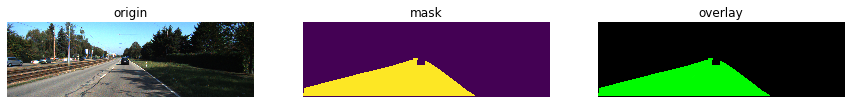

In [33]:
for _, sample in enumerate(training_set.take(1)):
    original_image = sample[0]
    mask = sample[1]
    
    overlay = create_overlay(original_image, mask)
    display_images([original_image, mask, overlay], ['origin', 'mask', 'overlay'])

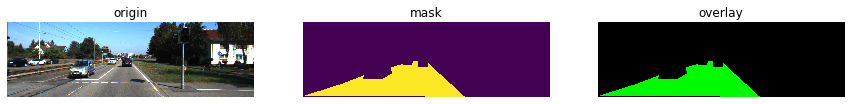

In [34]:
for _, sample in enumerate(validation_set.take(1)):
    original_image = sample[0]
    mask = sample[1]
    
    overlay = create_overlay(original_image, mask)
    display_images([original_image, mask, overlay], ['origin', 'mask', 'overlay'])

## Define callbacks

In [35]:
log_directory = (output_parameters['output_folder'] +
                 output_parameters['log_folder'] +
                 datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_directory)

In [41]:
checkpoint_directory = (output_parameters['output_folder'] + output_parameters['checkpoint_folder'])
checkpoint_callback = create_checkpoint_callback(checkpoint_directory, save_weights=True,
                                                 save_freq=SAVE_CHECKPOINT_STEPS)

## Compile and train the model

In [42]:
footpath_model.compile(optimizer=Adam(learning_rate=compiler_parameters['learning_rate'],
                                      epsilon=compiler_parameters['epsilon']),
                       loss=BinaryCrossentropy(from_logits=False),
                       metrics=[tf.keras.metrics.BinaryCrossentropy()])

In [ ]:
model_history = footpath_model.fit(training_set,
                                   epochs=solver_parameters['epochs'],
                                   steps_per_epoch=TRAINING_STEPS,
                                   validation_steps=VALIDATION_STEPS,
                                   validation_data=validation_set,
                                   callbacks=[checkpoint_callback, tensorboard_callback])

Train for 231 steps, validate for 58 steps
Epoch 1/120
214/231 [==========================>...] - ETA: 7s - loss: 0.6082 - binary_crossentropy: 0.5391

## Save final weights and trained model

In [35]:
output_model_directory = output_parameters['output_folder'] + output_parameters['output_model']
weights_directory = output_parameters['output_folder'] + output_parameters['weights']

In [ ]:
footpath_model.save(filepath=output_model_directory)
footpath_model.save_weights(filepath=weights_directory)

## Test the model

In [61]:
# Load a random test image
test_image = load_random_image(testing_parameters['test_data_directory'],
                               image_dimension=(input_parameters['width'], input_parameters['height']))

In [177]:
# Load a specific image
# test_image = tf.keras.preprocessing.image.load_img('./data/examples/uu_000088.png',
#                                                   target_size=(input_parameters['width'],
#                                                                input_parameters['height']))

In [178]:
preprocessed_test_image = preprocess_image(test_image, expand_dimension=True)

In [179]:
output = footpath_model.predict(preprocessed_test_image)

In [180]:
overlay = create_overlay(test_image, output, alpha=0.3, from_prediction=True)

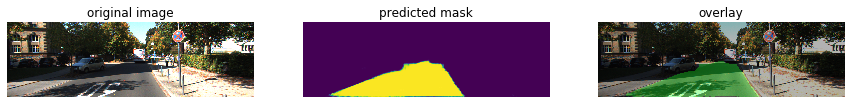

In [181]:
display_images([test_image, output, overlay], ['original image', 'predicted mask', 'overlay'])

In [5]:
#footpath_model = tf.keras.models.load_model('training_output-120e/fm_model.h5')